# CNN   small datasets 학습


- 학습할 Data의 개수가 많지 않을 때 CNN을 통한 모형 학습이 어려울 수 있음
  - 딥러닝은 많은 수의 데이터를 통해 feature engineering 과정 없이 원하는 문제를 해결할 수 있다. => **Point: 많은 데이터 수**
- Data가 많지 않아 CNN 학습에 어려움이 있을 때 사용 가능한 방법
    - Data augmentation 활용
        - 원본 이미지의 색깔, 각도 등을 약간씩 변형한 이미지들을 추가로 만들어 data의 수를 늘림 
    - Pre-trained network의 활용
        - 매우 큰 데이터셋으로 미리 Training한 모델의 파라미터(가중치)를 가져와서 풀려는 문제에 맞게 모델을 재보정해서 사용한다.
        - 성능이 좋은 학습된 모델을 사용하므로 적은 데이터에도 좋은 성능을 낼 수있다.

## Data for cats vs. dogs
- 2013년 Kaggle의 computer vision competition data 활용 https://www.kaggle.com/c/dogs-vs-cats/data
- 개와 고양이를 구분하기 위한 문제로 각 12,500개의 이미지를 포함
- Medium-resolution color JPEGs
- 25000장의 사진 중 4000장의 cats/dogs 사진(2000 cats, 2000 dogs) 만을 사용하여 학습하여 좋은 모형을 만들어 낼 수 있을까?
    - 학습: 2000, 검증: 1000, 테스트: 1000
    
![cats_vs_dogs_samples](https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg)

##### 이미지 다운로드
- gdown 패키지 : 구글 드라이브의 공유파일 다운로드 패키지    
- `pip install gdown`
- 코랩에는 설치 되어 있음.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install gdown --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [3]:
import gdown
from zipfile import ZipFile
import os

def down_extract():
    url = 'https://drive.google.com/uc?id=1nBE3N2cXQGwD8JaD0JZ2LmFD-n3D5hVU'
    fname = 'cats_and_dogs_small.zip'   # 다운받아서 저장할 파일 이름.
    # 다운로드
    gdown.download(url, fname, quiet=False)
    # 압축풀기
    with ZipFile(fname) as zipFile: # 압축파일의 경로를 넣어서  ZipFile 객체 생성
        zipFile.extractall('data/cats_and_dogs_small')  # 압축 풀 디렉토리 넣어서 실행.

In [4]:
down_extract()

Downloading...
From: https://drive.google.com/uc?id=1nBE3N2cXQGwD8JaD0JZ2LmFD-n3D5hVU
To: /content/cats_and_dogs_small.zip
100%|██████████| 90.8M/90.8M [00:00<00:00, 282MB/s]


# 하이퍼파라미터 정의

In [1]:
LEARNING_RATE = 0.001
N_EPOCH = 200
N_BATCH = 100

## 모델 구현 및 학습

- Input: $224 \times 224$ 픽셀의 RGB layer 
- Output: cat or dog (binary classification)  
- ImageDataGenerator를 이용해 파일시스템에 저장된 이미지 데이터셋을 학습시킨다.

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import random 

random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

In [3]:
# 모델 생성
def get_model():
    model = keras.Sequential()

    model.add(layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape=(224, 224, 3)))
    model.add(layers.MaxPooling2D(padding='same'))

    model.add(layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(padding='same'))

    model.add(layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(padding='same'))

    model.add(layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(padding='same'))

    model.add(layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(padding='same'))

    model.add(layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(padding='same'))

    model.add(layers.Flatten())
    model.add(layers.Dropout(rate=0.5))
    # model.add(layers.Dense(units=2, activation='softmax', name='multi_classification')) #다중분류 -  loss=categorical_crossentropy
    model.add(layers.Dense(units=1, activation='sigmoid', name='binary_classification_output')) # 2진 분류

    model.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE), 
                 loss='binary_crossentropy', metrics=['accuracy'])
    return model


# ImageDataGenerator 생성

In [8]:
# 데이터셋 디렉토리 경로
trainset_dir = 'data/cats_and_dogs_small/train'
valset_dir = 'data/cats_and_dogs_small/validation/'
testset_dir = 'data/cats_and_dogs_small/test/'

In [9]:
# image augmentation 미적용
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Iterator 생성->raw data파일과 연결.
train_iter = train_datagen.flow_from_directory(trainset_dir, # Image File들이 저장된 경로
                                               target_size=(224,224), # 이미지를 읽어오면서 resize할 크기. (height, width)
                                               class_mode='binary', # output(y) 처리 방식. 
                                               batch_size=N_BATCH   # 배치 size 지정.
                                               )

val_iter = val_datagen.flow_from_directory(valset_dir, target_size=(224, 224), class_mode='binary', batch_size=N_BATCH)
test_iter = test_datagen.flow_from_directory(testset_dir, target_size=(224, 224), class_mode='binary', batch_size=N_BATCH)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
train_iter.class_indices  # Label 확인.

{'cats': 0, 'dogs': 1}

In [11]:
print('에폭당 step 수')
print(len(train_iter), len(val_iter), len(test_iter))

에폭당 step 수
20 10 10


In [12]:
v = next(train_iter)
print(type(v))
print(v[0].shape)  # X(이미지) - (100, 224, 224, 3)  (batch수, (224, 224, 3->이미지한장의 크기))
print(v[1].shape)  # y(label)

<class 'tuple'>
(100, 224, 224, 3)
(100,)


In [13]:
v[1][:10]

array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)


##  Model Training(학습)

In [14]:
g_drive_path = '/content/drive/MyDrive/'
save_dir_path = os.path.join(g_drive_path, 'saved_model', 'cat_dog_model_no_aug')
os.makedirs(save_dir_path, exist_ok=True)

save_weight_path = os.path.join(save_dir_path, 'ckpt')

mc_callback = keras.callbacks.ModelCheckpoint(filepath=save_weight_path, 
                                              save_weights_only=True, # 파라미터만 저장
                                              save_best_only=True, # 성능이 개선된 에폭것만 저장
                                              monitor='val_loss', verbose=1)

es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)

In [15]:
model = get_model()
hist = model.fit(train_iter, epochs=N_EPOCH,
                 steps_per_epoch=len(train_iter), # 1에폭당 step수
                 validation_data=val_iter, 
                 validation_steps=len(val_iter), # 1 에폭당 step수
                 callbacks=[mc_callback, es_callback]
                 )

Epoch 1/200
20/20 [==============================] - ETA: 0s - loss: 0.6934 - accuracy: 0.5030
Epoch 1: val_loss improved from inf to 0.69162, saving model to /content/drive/MyDrive/saved_model/cat_dog_model_no_aug/ckpt
20/20 [==============================] - 27s 668ms/step - loss: 0.6934 - accuracy: 0.5030 - val_loss: 0.6916 - val_accuracy: 0.5320
Epoch 2/200
20/20 [==============================] - ETA: 0s - loss: 0.6830 - accuracy: 0.5650
Epoch 2: val_loss improved from 0.69162 to 0.64485, saving model to /content/drive/MyDrive/saved_model/cat_dog_model_no_aug/ckpt
20/20 [==============================] - 13s 653ms/step - loss: 0.6830 - accuracy: 0.5650 - val_loss: 0.6449 - val_accuracy: 0.6040
Epoch 3/200
20/20 [==============================] - ETA: 0s - loss: 0.6269 - accuracy: 0.6505
Epoch 3: val_loss did not improve from 0.64485
20/20 [==============================] - 13s 646ms/step - loss: 0.6269 - accuracy: 0.6505 - val_loss: 0.6473 - val_accuracy: 0.5940
Epoch 4/200
20/20 

loss: 0.4136 - accuracy: 0.8115 - val_loss: 0.4708 - val_accuracy: 0.7760    
loss: 0.1381 - accuracy: 0.9420 - val_loss: 0.7618 - val_accuracy: 0.7530

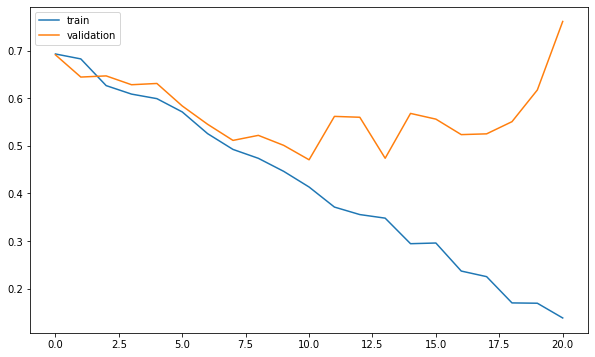

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(hist.epoch, hist.history['loss'], label='train')
plt.plot(hist.epoch, hist.history['val_loss'], label='validation')
plt.legend()
plt.show()

##### 저장된 모델 조회

In [19]:
# 모델 생성
saved_model1 = get_model()
saved_model1.evaluate(test_iter)

10/10 [==============================] - 4s 351ms/step - loss: 0.6929 - accuracy: 0.5030


[0.6929490566253662, 0.503000020980835]

In [21]:
# 생성된 모델에 저장된 파라미터 덮어씌우기
saved_model1.load_weights(save_weight_path)
saved_model1.evaluate(test_iter)

10/10 [==============================] - 4s 413ms/step - loss: 0.4881 - accuracy: 0.7810


[0.4880965054035187, 0.781000018119812]

In [27]:
# -np.log(0.62)
-np.log(0.5)

0.6931471805599453

# 새로운 데이터 추론

In [4]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_preprocessing(image_path):
    """
    경로의 이미지를 읽어서 전처리(scaling) 한 뒤 반환.
    """
    raw_img = load_img(image_path, target_size=(224,224))  # Pillow Image객체로 읽어오기. target_size를 설정하면 resize해서 읽어온다.
    img_array = img_to_array(raw_img)
    img_array = img_array[np.newaxis, ...]  # batch 축 늘리기 (224,224,3) => (1, 224, 224, 3)
    img_array = img_array.astype('float32')/255   # float 타입으로 변환 후 255로 나눠서 scaling
    return img_array

In [35]:
from keras.saving.legacy import saved_model
new_img_path = 'dog.jpg'
new_img_path = 'dog2.jpg'
new_img_path = 'cat.jpg'
new_img_path = 'cat2.jpg'
new_X = load_preprocessing(new_img_path)

pred = saved_model1.predict(new_X)
print(pred)
print(np.where(pred>=0.5, "개", "고양이"))

1/1 [==============================] - 0s 22ms/step
[[0.13196795]]
[['고양이']]


In [30]:
train_iter.class_indices

{'cats': 0, 'dogs': 1}

# Image data augmentation 사용

- 학습 이미지의 수가 적어서 overfitting이 발생할 가능성을 줄이기 위해 기존 훈련 데이터로부터 그럴듯하게 이미지 변환을 통해서 이미지(데이터)를 늘리는 작업을 Image augmentation
- train_set에만 적용, validation, test set에는 적용하지 않는다. (rescaling만 한다.)

##### 하이퍼파라미터 정의

##### ImageDataGenerator 생성

In [10]:
# 데이터셋 디렉토리 경로
trainset_dir = 'data/cats_and_dogs_small/train'
valset_dir = 'data/cats_and_dogs_small/validation/'
testset_dir = 'data/cats_and_dogs_small/test/'

In [11]:
# train ImageDataGenerator 생성 => Image Augmentation 설정 (train set에만 설정. )
train_datagen2 = ImageDataGenerator(rescale=1./255, 
                                    rotation_range=40, 
                                    width_shift_range=0.2, 
                                    height_shift_range=0.2, 
                                    # shear_range=0.2, 
                                    zoom_range=0.2, 
                                    horizontal_flip=True, 
                                    # vertical_flip=True, 
                                    # brightness_range=(0.5, 1.5), 
                                    fill_mode='constant')

val_datagen2 = ImageDataGenerator(rescale=1./255)
test_datagen2 = ImageDataGenerator(rescale=1./255)

In [12]:
train_iter2 = train_datagen2.flow_from_directory(trainset_dir, target_size=(224,224), class_mode='binary', 
                                                 batch_size=N_BATCH)

val_iter2 = val_datagen2.flow_from_directory(valset_dir, target_size=(224,224), class_mode='binary', batch_size=N_BATCH)

test_iter2 = test_datagen2.flow_from_directory(testset_dir, target_size=(224,224), class_mode='binary', batch_size=N_BATCH)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


##### 모델 생성, 컴파일, 학습

In [14]:
g_drive_path = '/content/drive/MyDrive'
save_dir_path = os.path.join(g_drive_path, "saved_model", "cat_dog_model_aug") # model 저장 경로(model+파라미터)
mc_callback2 = keras.callbacks.ModelCheckpoint(save_dir_path, save_best_only=True, monitor='val_loss', verbose=1)
es_callback2 = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)


model2 = get_model()
# ImageDataGenerator는 데이터를 무한제공하기 때문에 1 epoch이 언제 끝나는 지를 알수 없다. => 
#     steps_per_epoch/validation_steps 에 1 epcoh이 몇 step인지를 설정해서 직접 알려줘야 한다.
hist2 = model2.fit(train_iter2, epochs=N_EPOCH, 
                   steps_per_epoch=len(train_iter2), 
                   validation_data=val_iter2, 
                   validation_steps=len(val_iter2), 
                   callbacks=[mc_callback2, es_callback2])

Epoch 1/200
20/20 [==============================] - ETA: 0s - loss: 0.6988 - accuracy: 0.5130
Epoch 1: val_loss improved from inf to 0.69304, saving model to /content/drive/MyDrive/saved_model/cat_dog_model_aug


20/20 [==============================] - 35s 2s/step - loss: 0.6988 - accuracy: 0.5130 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 2/200
20/20 [==============================] - ETA: 0s - loss: 0.6923 - accuracy: 0.5150
Epoch 2: val_loss improved from 0.69304 to 0.69188, saving model to /content/drive/MyDrive/saved_model/cat_dog_model_aug


20/20 [==============================] - 34s 2s/step - loss: 0.6923 - accuracy: 0.5150 - val_loss: 0.6919 - val_accuracy: 0.5170
Epoch 3/200
20/20 [==============================] - ETA: 0s - loss: 0.6928 - accuracy: 0.5190
Epoch 3: val_loss improved from 0.69188 to 0.69037, saving model to /content/drive/MyDrive/saved_model/cat_dog_model_aug


20/20 [==============================] - 33s 2s/step - loss: 0.6928 - accuracy: 0.5190 - val_loss: 0.6904 - val_accuracy: 0.6040
Epoch 4/200
20/20 [==============================] - ETA: 0s - loss: 0.6903 - accuracy: 0.5370
Epoch 4: val_loss did not improve from 0.69037
20/20 [==============================] - 31s 2s/step - loss: 0.6903 - accuracy: 0.5370 - val_loss: 0.6921 - val_accuracy: 0.5080
Epoch 5/200
20/20 [==============================] - ETA: 0s - loss: 0.6913 - accuracy: 0.5190
Epoch 5: val_loss improved from 0.69037 to 0.68643, saving model to /content/drive/MyDrive/saved_model/cat_dog_model_aug


20/20 [==============================] - 33s 2s/step - loss: 0.6913 - accuracy: 0.5190 - val_loss: 0.6864 - val_accuracy: 0.5810
Epoch 6/200
20/20 [==============================] - ETA: 0s - loss: 0.6878 - accuracy: 0.5480
Epoch 6: val_loss improved from 0.68643 to 0.67021, saving model to /content/drive/MyDrive/saved_model/cat_dog_model_aug


20/20 [==============================] - 33s 2s/step - loss: 0.6878 - accuracy: 0.5480 - val_loss: 0.6702 - val_accuracy: 0.5940
Epoch 7/200
20/20 [==============================] - ETA: 0s - loss: 0.6806 - accuracy: 0.5700
Epoch 7: val_loss improved from 0.67021 to 0.65814, saving model to /content/drive/MyDrive/saved_model/cat_dog_model_aug


20/20 [==============================] - 34s 2s/step - loss: 0.6806 - accuracy: 0.5700 - val_loss: 0.6581 - val_accuracy: 0.6000
Epoch 8/200
20/20 [==============================] - ETA: 0s - loss: 0.6797 - accuracy: 0.5750
Epoch 8: val_loss did not improve from 0.65814
20/20 [==============================] - 31s 2s/step - loss: 0.6797 - accuracy: 0.5750 - val_loss: 0.6677 - val_accuracy: 0.6390
Epoch 9/200
20/20 [==============================] - ETA: 0s - loss: 0.6743 - accuracy: 0.5780
Epoch 9: val_loss did not improve from 0.65814
20/20 [==============================] - 31s 2s/step - loss: 0.6743 - accuracy: 0.5780 - val_loss: 0.6788 - val_accuracy: 0.5710
Epoch 10/200
20/20 [==============================] - ETA: 0s - loss: 0.6654 - accuracy: 0.6140
Epoch 10: val_loss improved from 0.65814 to 0.64722, saving model to /content/drive/MyDrive/saved_model/cat_dog_model_aug


20/20 [==============================] - 34s 2s/step - loss: 0.6654 - accuracy: 0.6140 - val_loss: 0.6472 - val_accuracy: 0.6490
Epoch 11/200
20/20 [==============================] - ETA: 0s - loss: 0.6523 - accuracy: 0.6235
Epoch 11: val_loss improved from 0.64722 to 0.64406, saving model to /content/drive/MyDrive/saved_model/cat_dog_model_aug


20/20 [==============================] - 33s 2s/step - loss: 0.6523 - accuracy: 0.6235 - val_loss: 0.6441 - val_accuracy: 0.6390
Epoch 12/200
20/20 [==============================] - ETA: 0s - loss: 0.6471 - accuracy: 0.6335
Epoch 12: val_loss did not improve from 0.64406
20/20 [==============================] - 31s 2s/step - loss: 0.6471 - accuracy: 0.6335 - val_loss: 0.6459 - val_accuracy: 0.6530
Epoch 13/200
20/20 [==============================] - ETA: 0s - loss: 0.6442 - accuracy: 0.6225
Epoch 13: val_loss improved from 0.64406 to 0.61678, saving model to /content/drive/MyDrive/saved_model/cat_dog_model_aug


20/20 [==============================] - 33s 2s/step - loss: 0.6442 - accuracy: 0.6225 - val_loss: 0.6168 - val_accuracy: 0.6570
Epoch 14/200
20/20 [==============================] - ETA: 0s - loss: 0.6186 - accuracy: 0.6670
Epoch 14: val_loss improved from 0.61678 to 0.61456, saving model to /content/drive/MyDrive/saved_model/cat_dog_model_aug


20/20 [==============================] - 32s 2s/step - loss: 0.6186 - accuracy: 0.6670 - val_loss: 0.6146 - val_accuracy: 0.6550
Epoch 15/200
20/20 [==============================] - ETA: 0s - loss: 0.6012 - accuracy: 0.6795
Epoch 15: val_loss did not improve from 0.61456
20/20 [==============================] - 32s 2s/step - loss: 0.6012 - accuracy: 0.6795 - val_loss: 0.6458 - val_accuracy: 0.6560
Epoch 16/200
20/20 [==============================] - ETA: 0s - loss: 0.5859 - accuracy: 0.6945
Epoch 16: val_loss improved from 0.61456 to 0.56418, saving model to /content/drive/MyDrive/saved_model/cat_dog_model_aug


20/20 [==============================] - 33s 2s/step - loss: 0.5859 - accuracy: 0.6945 - val_loss: 0.5642 - val_accuracy: 0.7100
Epoch 17/200
20/20 [==============================] - ETA: 0s - loss: 0.6015 - accuracy: 0.6700
Epoch 17: val_loss did not improve from 0.56418
20/20 [==============================] - 32s 2s/step - loss: 0.6015 - accuracy: 0.6700 - val_loss: 0.6250 - val_accuracy: 0.6410
Epoch 18/200
20/20 [==============================] - ETA: 0s - loss: 0.6080 - accuracy: 0.6740
Epoch 18: val_loss did not improve from 0.56418
20/20 [==============================] - 31s 2s/step - loss: 0.6080 - accuracy: 0.6740 - val_loss: 0.6243 - val_accuracy: 0.6530
Epoch 19/200
20/20 [==============================] - ETA: 0s - loss: 0.5902 - accuracy: 0.6805
Epoch 19: val_loss did not improve from 0.56418
20/20 [==============================] - 32s 2s/step - loss: 0.5902 - accuracy: 0.6805 - val_loss: 0.5871 - val_accuracy: 0.6960
Epoch 20/200
20/20 [==============================] 

20/20 [==============================] - 32s 2s/step - loss: 0.5940 - accuracy: 0.6855 - val_loss: 0.5524 - val_accuracy: 0.7290
Epoch 21/200
20/20 [==============================] - ETA: 0s - loss: 0.5742 - accuracy: 0.7070
Epoch 21: val_loss improved from 0.55241 to 0.54322, saving model to /content/drive/MyDrive/saved_model/cat_dog_model_aug


20/20 [==============================] - 32s 2s/step - loss: 0.5742 - accuracy: 0.7070 - val_loss: 0.5432 - val_accuracy: 0.7220
Epoch 22/200
20/20 [==============================] - ETA: 0s - loss: 0.5530 - accuracy: 0.7315
Epoch 22: val_loss improved from 0.54322 to 0.53155, saving model to /content/drive/MyDrive/saved_model/cat_dog_model_aug


20/20 [==============================] - 33s 2s/step - loss: 0.5530 - accuracy: 0.7315 - val_loss: 0.5315 - val_accuracy: 0.7260
Epoch 23/200
20/20 [==============================] - ETA: 0s - loss: 0.5542 - accuracy: 0.7210
Epoch 23: val_loss did not improve from 0.53155
20/20 [==============================] - 32s 2s/step - loss: 0.5542 - accuracy: 0.7210 - val_loss: 0.5536 - val_accuracy: 0.7160
Epoch 24/200
20/20 [==============================] - ETA: 0s - loss: 0.5362 - accuracy: 0.7210
Epoch 24: val_loss improved from 0.53155 to 0.50164, saving model to /content/drive/MyDrive/saved_model/cat_dog_model_aug


20/20 [==============================] - 34s 2s/step - loss: 0.5362 - accuracy: 0.7210 - val_loss: 0.5016 - val_accuracy: 0.7530
Epoch 25/200
20/20 [==============================] - ETA: 0s - loss: 0.5320 - accuracy: 0.7355
Epoch 25: val_loss did not improve from 0.50164
20/20 [==============================] - 32s 2s/step - loss: 0.5320 - accuracy: 0.7355 - val_loss: 0.5895 - val_accuracy: 0.7070
Epoch 26/200
20/20 [==============================] - ETA: 0s - loss: 0.5341 - accuracy: 0.7340
Epoch 26: val_loss did not improve from 0.50164
20/20 [==============================] - 32s 2s/step - loss: 0.5341 - accuracy: 0.7340 - val_loss: 0.5932 - val_accuracy: 0.6970
Epoch 27/200
20/20 [==============================] - ETA: 0s - loss: 0.5188 - accuracy: 0.7555
Epoch 27: val_loss did not improve from 0.50164
20/20 [==============================] - 31s 2s/step - loss: 0.5188 - accuracy: 0.7555 - val_loss: 0.5198 - val_accuracy: 0.7460
Epoch 28/200
20/20 [==============================] 

20/20 [==============================] - 32s 2s/step - loss: 0.4966 - accuracy: 0.7630 - val_loss: 0.4985 - val_accuracy: 0.7600
Epoch 33/200
20/20 [==============================] - ETA: 0s - loss: 0.4899 - accuracy: 0.7745
Epoch 33: val_loss improved from 0.49845 to 0.45012, saving model to /content/drive/MyDrive/saved_model/cat_dog_model_aug


20/20 [==============================] - 34s 2s/step - loss: 0.4899 - accuracy: 0.7745 - val_loss: 0.4501 - val_accuracy: 0.7910
Epoch 34/200
20/20 [==============================] - ETA: 0s - loss: 0.4880 - accuracy: 0.7715
Epoch 34: val_loss did not improve from 0.45012
20/20 [==============================] - 31s 2s/step - loss: 0.4880 - accuracy: 0.7715 - val_loss: 0.4825 - val_accuracy: 0.7710
Epoch 35/200
20/20 [==============================] - ETA: 0s - loss: 0.5130 - accuracy: 0.7610
Epoch 35: val_loss did not improve from 0.45012
20/20 [==============================] - 30s 2s/step - loss: 0.5130 - accuracy: 0.7610 - val_loss: 0.4905 - val_accuracy: 0.7530
Epoch 36/200
20/20 [==============================] - ETA: 0s - loss: 0.4865 - accuracy: 0.7745
Epoch 36: val_loss did not improve from 0.45012
20/20 [==============================] - 32s 2s/step - loss: 0.4865 - accuracy: 0.7745 - val_loss: 0.5113 - val_accuracy: 0.7580
Epoch 37/200
20/20 [==============================] 

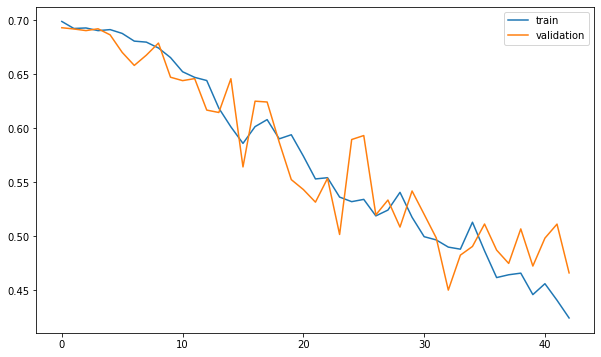

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(hist2.epoch, hist2.history['loss'], label='train')
plt.plot(hist2.epoch, hist2.history['val_loss'], label='validation')
plt.legend()
plt.show()

##### 저장된 모델 Loading 후 평가(사용)

##### 새로운데이터 추론